In [1]:
import os
import datetime
import time

import ipywidgets as widgets

import IPython
import IPython.display
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from math import sqrt
from numpy import concatenate
import numpy as np
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# import tensorflow 
# import tensorflow as tf
# from tensorflow import keras

import platform
# print(platform.python_version())
# print(tf.version.VERSION)
# print(np.__version__)



In [2]:
# File name and Path
cwd = os.getcwd()
path_adress = "/Import_Dataset/"

# ข้อมูล พิกัดสถานที่เเละรายชื้ออ้างอิงสถานที่ตรวจวัด
file_name_st = 'Data_lat_long_Rice research Center'
csv_file_st = cwd + path_adress + file_name_st + '.csv'

df_st = pd.read_csv(csv_file_st)
print("All low RiceCenter {} station" .format(df_st.shape[0]))

data_list_st_num = list(range(1, len(df_st)))
data_list_st_name = []
data_list_st_name = df_st['nameEng'].values.tolist()
data_list_st_lat = df_st['Latitude'].values.tolist()
data_list_st_long = df_st['Longitude'].values.tolist()

All low RiceCenter 34 station


In [3]:
st = 10
# st_num = 1
file_name = df_st['nameEng'][data_list_st_num[st]]
name_input = file_name
name_locals = 'stN_' + file_name
print(name_locals)

# File name and Path
csv_file = cwd + path_adress + name_input + '.csv'
# index_col=0 , index_col=None
dataset = pd.read_csv(csv_file, header=0,
                      index_col=0, encoding="TIS-620")
# dataset = dataset.drop(['address'], axis=1)
# dataset = dataset.drop(['year'], axis=1)
# dataset = dataset.drop(['dew'], axis=1)
header_name = list(dataset)
print(header_name)

stN_Lopburi Rice Seed Center
['address', 'latitude', 'longitude', 'day', 'month', 'year', 'mirid bug', 'mint', 'maxt', 'temp', 'dew', 'humidity', 'wspd', 'wdir', 'precip', 'R-1', 'R-2', 'R-3', 'R-4', 'R-5', 'R-6', 'R-7', 'R-8', 'R-9', 'R-10', 'R-11', 'R-12', 'R-13', 'R-14', 'R-15', 'R-16', 'R-17', 'R-18', 'R-19', 'R-20', 'bph']


In [4]:
# df_temperature = dataset['temp']
df_temperature = pd.DataFrame(dataset['bph'].loc['2015-01-01':'2015-01-31']) 

# df_temperature = 
# the simple moving average over a period of 10 years
# df_temperature['7D-SMA'] = df_temperature.bph.rolling(7, min_periods=1).mean()
# df_temperature['3D-SMA'] = df_temperature.bph.rolling(3, min_periods=1).mean()
df_temperature['7D-SMA'] = df_temperature.bph.rolling(7, min_periods=1).sum()
df_temperature['3D-SMA'] = df_temperature.bph.rolling(3, min_periods=1).sum()
# df_temperature

Text(0, 0.5, 'Temperature [°C]')

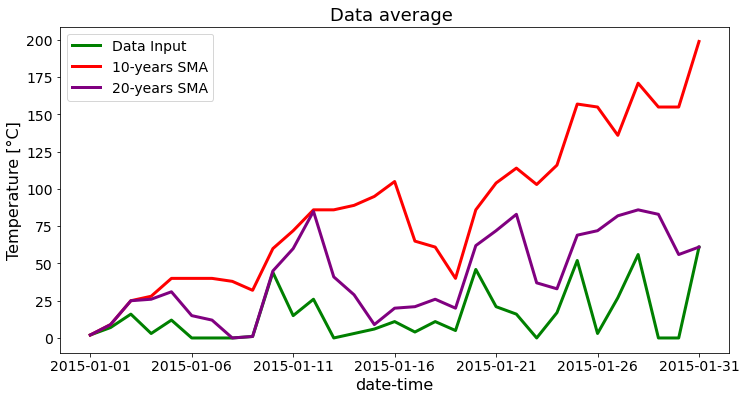

In [5]:
# colors for the line plot
colors = ['green', 'red', 'purple']

# line plot - the yearly average air temperature in Barcelona
df_temperature.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Data Input', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('Data average ', fontsize=18)
plt.xlabel('date-time', fontsize=16)
plt.ylabel('Temperature [°C]', fontsize=16)

In [6]:
#defining rate
our_rate = 6 
#apply the rate
constant_subset = df_temperature[::our_rate] 
#data
constant_subset

,bph,7D-SMA,3D-SMA
date,,,
2015-01-01,2,2.0,2.0
2015-01-07,0,40.0,12.0
2015-01-13,0,86.0,41.0
2015-01-19,5,40.0,20.0
2015-01-25,52,157.0,69.0
2015-01-31,61,199.0,61.0


In [7]:
def creat_dataset(st_BPH=0, y_1='2015', y_2='2019', mode=1):
    for i in range(len(data_list_st_num)):
        st = i
        file_name = df_st['nameEng'][data_list_st_num[st]]
        name_input = file_name
        name_locals = 'stN_' + file_name

        # File name and Path
        csv_file = cwd + path_adress + name_input + '.csv'
        # index_col=0 , index_col=None
        dataset = pd.read_csv(csv_file, header=0,
                              index_col=0, encoding="TIS-620")
        dataset = dataset.drop(['address'], axis=1)
        dataset = dataset.drop(['year'], axis=1)
        dataset = dataset.drop(['dew'], axis=1)
        # dataset = dataset.drop(['latitude'], axis=1)
        # dataset = dataset.drop(['longitude'], axis=1)
        dataset.columns
        locals()[name_locals] = dataset
        # print(f'Dataframe name_station: {st+1 , name_input}')
        print('wait......')
        del dataset
        clear_output(wait=True)

    date_start = y_1 + '-01' + '-01'
    date_stop = y_2 + '-12' + '-31'

#---------------------------------------------------------------------------------------------------------------------------------------------------#
    if mode == 0:
        file_name = df_st['nameEng'][st_BPH]
        locals_input = 'stN_' + file_name
        print(locals_input)
        dataset_st = locals()[locals_input].loc[date_start:date_stop]
        frames_st = dataset_st
    else:
        m = 0
        for j in range(len(data_list_st_num)):
            # for j in range(df_st.shape[0]):
            # file_name = df_st['nameEng'][j]
            file_name = df_st['nameEng'][data_list_st_num[j]]
            locals_input = 'stN_' + file_name
            print(locals_input)
            dataset_st = locals()[locals_input].loc[date_start:date_stop]
            clear_output(wait=True)
            if m == 0:
                frames_st = dataset_st
                m = m+1
                print(m)
            else:
                frames_st = [frames_st, dataset_st]
                frames_st = pd.concat(frames_st)
#---------------------------------------------------------------------------------------------------------------------------------------------------#
    # frames=frames_st[new_colum_2]
    frames = frames_st
    return frames


In [25]:
frames_train = creat_dataset(0,'2015','2019',1)

df = frames_train.reset_index()
date_time_predict = pd.to_datetime(df.pop('date'))

# date_time_predict
df

,latitude,longitude,day,month,mirid bug,mint,maxt,temp,humidity,wspd,...,R-12,R-13,R-14,R-15,R-16,R-17,R-18,R-19,R-20,bph
0,15.198,100.137,1,1,0,24.8,28.9,27.1,33.32,35.6,...,0,0,27787,218,576,550,1004,12125,1576,0
1,15.198,100.137,2,1,0,21.2,27.2,24.2,43.19,21.6,...,0,0,27787,218,576,550,1004,12125,1576,1
2,15.198,100.137,3,1,0,23.7,29.9,27.4,44.43,10.7,...,0,0,27787,218,576,550,1004,12125,1576,3
3,15.198,100.137,4,1,0,25.9,30.1,28.0,45.44,8.8,...,0,0,27787,218,576,550,1004,12125,1576,104
4,15.198,100.137,5,1,0,26.7,26.7,26.7,58.27,0.0,...,0,0,27787,218,576,550,1004,12125,1576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60253,17.374,102.584,27,12,0,22.0,29.2,26.3,62.20,12.8,...,0,17399,6481,0,6595,300,1112,62,0,0
60254,17.374,102.584,28,12,0,21.0,22.9,22.0,65.25,11.2,...,0,17399,6481,0,6595,300,1112,62,0,0
60255,17.374,102.584,29,12,0,19.0,29.9,26.2,57.34,12.4,...,0,17399,6481,0,6595,300,1112,62,0,0
60256,17.374,102.584,30,12,0,18.9,27.0,23.7,70.37,9.2,...,0,17399,6481,0,6595,300,1112,62,0,0


In [38]:
# frames_train
our_rate = 6 

#conditonal sampling
our_condition = df['latitude'] == 15.198

#Retirive the index
index = our_condition[our_condition == True].index
 
#sample based on condition 
conditional_subset = df[our_condition][::our_rate] 
 
#output 
df2 = conditional_subset.set_index()
df2

TypeError: set_index() missing 1 required positional argument: 'keys'

In [35]:
our_condition

0         True
1         True
2         True
3         True
4         True
         ...  
60253    False
60254    False
60255    False
60256    False
60257    False
Name: latitude, Length: 60258, dtype: bool

In [15]:
#defining rate
our_rate = 6 
#apply the rate
constant_subset = df_temperature[::our_rate] 
#data
constant_subset

,latitude,longitude,day,month,mirid bug,mint,maxt,temp,humidity,wspd,...,R-12,R-13,R-14,R-15,R-16,R-17,R-18,R-19,R-20,bph
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,15.198,100.137,1,1,0,24.8,28.9,27.1,33.32,35.6,...,0,0,27787,218,576,550,1004,12125,1576,0
2015-01-02,15.198,100.137,2,1,0,21.2,27.2,24.2,43.19,21.6,...,0,0,27787,218,576,550,1004,12125,1576,1
2015-01-03,15.198,100.137,3,1,0,23.7,29.9,27.4,44.43,10.7,...,0,0,27787,218,576,550,1004,12125,1576,3
2015-01-04,15.198,100.137,4,1,0,25.9,30.1,28.0,45.44,8.8,...,0,0,27787,218,576,550,1004,12125,1576,104
2015-01-05,15.198,100.137,5,1,0,26.7,26.7,26.7,58.27,0.0,...,0,0,27787,218,576,550,1004,12125,1576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,15.198,100.137,27,12,0,30.0,32.5,31.3,54.53,17.6,...,0,0,42092,331,873,833,1521,18368,2388,6
2015-12-28,15.198,100.137,28,12,2,29.5,33.5,31.9,59.08,3.7,...,0,0,42092,331,873,833,1521,18368,2388,16
2015-12-29,15.198,100.137,29,12,1,28.1,32.2,30.1,54.43,9.0,...,0,0,42092,331,873,833,1521,18368,2388,16
